In [8]:
import torch
from torch import nn
from torch import distributions as D
from matplotlib import pyplot as plt

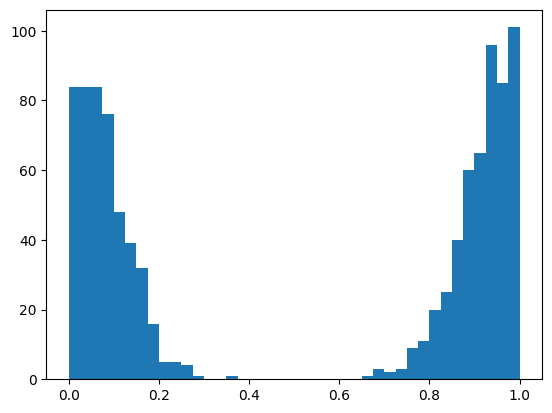

In [9]:
class ShiftedNormal(D.normal.Normal):
    def sample(self, sample_shape=torch.Size()):
        return (super().sample(sample_shape) % 1).unsqueeze(-1)

from lightning_trainable.datasets import DistributionDataset

class ShiftedGaussDataset(DistributionDataset):
    def __init__(self, dimensions: int = 1, **kwargs):
        distribution = ShiftedNormal(torch.zeros(dimensions), .1*torch.ones(dimensions))
        super().__init__(distribution, **kwargs)

    
x = ShiftedNormal(0, .1).sample((1000,))
bin_edges = plt.hist(x.detach().numpy(), bins=40)

In [10]:
from simplebg.latent import DistributionHParams
from simplebg.loss.core import LossWeights
from simplebg.model.core import ToyHParams, ToyModel
from simplebg.data.loaders import ToyLoader, ToyLoaderHParams

class GaussLoaderHParams(ToyLoaderHParams):
    name = "ShiftedGauss"
    kwargs = {"dimensions": 1}

class GaussLoader(ToyLoader):
    def __init__(self, loader_hparams: ToyLoaderHParams):
        super().__init__(loader_hparams)
        
    def generate_datasets(self):
        # calculate the split sizes
        train_split = int(self.hparams.train_split * self.hparams.samples)
        val_split = int(self.hparams.val_split * self.hparams.samples)
        test_split = self.hparams.samples - train_split - val_split
        # sanity test
        assert (self.hparams.samples * self.hparams.test_split - 2 <= test_split <=
                self.hparams.samples * self.hparams.test_split + 2), \
            "something has gone wrong with the calculation of test_split."

        ToyDataSet = ShiftedGaussDataset
        return (
            ToyDataSet(max_samples=train_split, **self.hparams.kwargs),
            ToyDataSet(max_samples=val_split, **self.hparams.kwargs),
            ToyDataSet(max_samples=test_split, **self.hparams.kwargs)
        )

class MyToyHParams(ToyHParams):
    loader_hparams: GaussLoaderHParams

class MyToyModel(ToyModel):
    loader_class = GaussLoader
    hparams: MyToyHParams

In [11]:
from simplebg.network.subnets.resnets import ResNetHParams
from simplebg.network.fff import SubNetFreeFormFlowHParams

loader_hparams = GaussLoaderHParams(
    train_split=0.75,
    val_split=0.05,
    test_split=0.2,
    kwargs={"dimensions": 1},
    samples=10_000,
)

resnet_network_hparams = ResNetHParams(
   depth_scheme=[6],
    width_scheme=[64],
    batch_norm=False,
)

fff_network_hparams = SubNetFreeFormFlowHParams(
    subnet_hparams=resnet_network_hparams,
    bottleneck=1,
    transform="identity",
)

hparams = MyToyHParams(
    loader_hparams=loader_hparams,
    network_hparams=fff_network_hparams,    
    latent_hparams=DistributionHParams(
        name="Normal",
        kwargs={"sigma": .1}
    ),
    loss_weights=LossWeights(
        forward_kl=1.,
        reconstruction=10.,
    ),
    max_epochs=20,
    batch_size=1_000,
    lr_scheduler="OneCycleLR",
    optimizer=dict(
        name="Adam",
        lr=1.e-3,
        betas=[.99, .9999],
    ),
    accelerator="auto",
    gradient_clip=10.,
)

trainer_kwargs = {"fast_dev_run": True, "enable_progress_bar": False}
logger_kwargs = {"name": "ShiftedGauss"}

In [12]:
from simplebg.network.fff import SubNetFreeFormFlow
SubNetFreeFormFlow.hparams_type

simplebg.network.fff.SubNetFreeFormFlowHParams

In [13]:
my_model = MyToyModel(hparams)
my_model.fit(trainer_kwargs=trainer_kwargs, logger_kwargs=logger_kwargs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name | Type               | Params
--------------------------------------------
0 | nn   | SubNetFreeFormFlow | 100 K 
--------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.401     Total estimated model params size (MB)


RuntimeError: output with shape [125, 1, 1] doesn't match the broadcast shape [125, 1, 125]

In [ ]:
my_model.nn.forward(x).output.squeeze(1)

In [ ]:
from lightning_trainable.hparams import HParams